# Generalized Method Of Moments with ARCH and GARCH Models

Autoregressive Conditionally Heteroskedastic (ARCH) process occurs when the volatility of a time series is also autoregressive.

In [10]:
import cvxopt
from functools import partial
import math
import numpy as np
import scipy
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.stattools import jarque_bera

import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Simulating a GARCH(1,1) case

We start by using Monte Carlo sampling to simulate a GARCH(1,1) process. Our dynamics are:

$$ \sigma_1 = \sqrt{\frac{a_0}{1-a_1-b_1}} \sigma^2_t =a_0+a_1 x^2_{t-1}+b_1 \sigma^2_{t-1} x_t = \sigma_t \epsilon_t \epsilon \sim \mathcal{N}(0,1) $$

In [2]:
# define parameters
a0 = 1.0
a1 = 0.1
b1 = 0.8
sigma1 = math.sqrt(a0 / (1 - a1 - b1))

In [3]:
def simulate_GARCH(T, a0, a1, b1, sigma1):
    
    # initialize our values
    X = np.ndarray(T)
    sigma = np.ndarray(T)
    sigma[0] = sigma1
    
    for t in range(1, T):
        # draw the next x_t
        X[t - 1] = sigma[t - 1] * np.random.normal(0, 1)
        # draw the next sigma_t
        sigma[t] = math.sqrt(a0 + b1 * sigma[t - 1]**2 + a1 * X[t - 1]**2)
        
    X[T - 1] = sigma[T - 1] * np.random.normal(0, 1)
    
    return X, sigma

Now we compare the tails of the GARCH(1,1) process with normally distributed values. We expect to see fatter tails, as the GARCH(1,1) process will experience extreme values more often.

In [4]:
X, _ = simulate_GARCH(10000, a0, a1, b1, sigma1)
X = X[1000:] # drop burn in
X = X / np.std(X) # normalize X

def compare_tails_to_normal(X):
    # define matrix to store comparisons
    A = np.zeros((2,4))
    for k in range(4):
        A[0, k] = len(X[X > (k + 1)]) / float(len(X)) # estimate tails of X
        A[1, k] = 1 - stats.norm.cdf(k + 1) # compare to Gaussian distribution
    return A

compare_tails_to_normal(X)

array([[1.56000000e-01, 2.34444444e-02, 2.44444444e-03, 3.33333333e-04],
       [1.58655254e-01, 2.27501319e-02, 1.34989803e-03, 3.16712418e-05]])

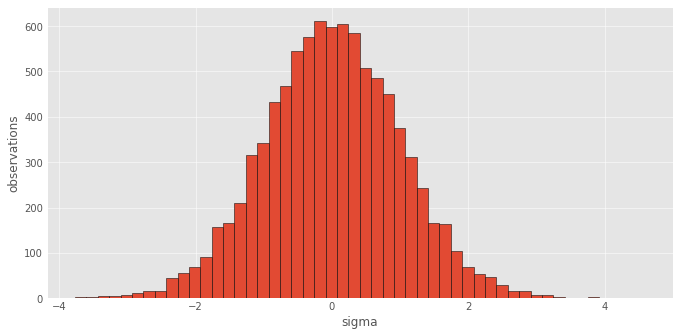

In [17]:
plt.figure(figsize=(10,5))
plt.hist(X, bins=50, edgecolor='black')
plt.xlabel('sigma')
plt.ylabel('observations');

In [12]:
# sample values from a normal distribution
X2 = np.random.normal(0, 1, 9000)
both = np.matrix([X, X2])

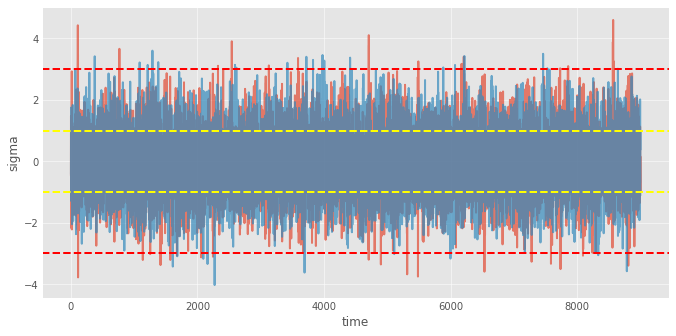

In [19]:
# plot both the GARCH and normal values
plt.figure(figsize=(10,5))
plt.plot(both.T, alpha=.7);
plt.axhline(X2.std(), color='yellow', linestyle='--')
plt.axhline(-X2.std(), color='yellow', linestyle='--')
plt.axhline(3*X2.std(), color='red', linestyle='--')
plt.axhline(-3*X2.std(), color='red', linestyle='--')
plt.xlabel('time')
plt.ylabel('sigma');

The GARCH process is shown in red and the normal process is in blue. The 1 and 3 std bars are drawn on the plot. We can see that the red GARCH process tends to cross the 3 std bar much more often than the blue normal one.

## Testing for ARCH behavior

The first step is to test for ARCH conditions. To do this we run a regression on $x_t$ fitting the following model.

$$x^2_t = a_0 + a_1 x^2_{t-1} + ... + a_p x^2_{t-p}$$

We use OLS to estimate $\hat \theta = (\hat a_0, \hat a_1,...,\hat a_p)$ and the covariance matrix $\hat \Omega$. We can then compute the test statistic:

$$F = \hat \theta \hat \Omega^{-1} \hat \theta' $$

We reject if $F$ is greater than the 95% confidence bars in the $(X)^2(p)$ distribution.

To test, we set $p=20$ and see what we get.

(20, 1)
F = 337.5294877950205
p-value = 0.0
[[ 77.3173396   32.35194282  59.4961364    7.27931956  19.99174559
   32.51150666  29.29746464  17.7745147   31.72820638  45.88608139
   -3.3937807   28.98828871  33.04070611  16.48954016  -1.22930528
   17.05383079  11.75679795  23.6768081  -33.77974336  28.84300559]]


/Users/corentinvibert/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  app.launch_new_instance()


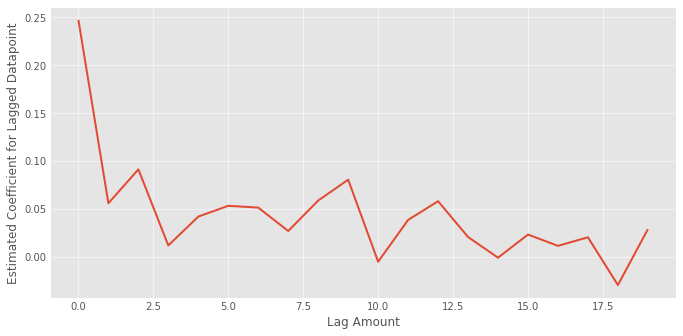

In [24]:
X, _ = simulate_GARCH(1100, a0, a1, b1, sigma1)
X = X[100:] # drop burn in

p = 20

# drop the first 20 so we have a lag of p's
Y2 = (X**2)[p:]
X2 = np.ndarray((980, p))
for i in range(p, 1000):
    X2[i - p, :] = np.asarray((X**2)[i-p:i])[::-1]
    
model = sm.OLS(Y2, X2)
model = model.fit()
theta = np.matrix(model.params)
omega = np.matrix(model.cov_HC0)
F = np.asscalar(theta * np.linalg.inv(omega) * theta.T)

print(np.asarray(theta.T).shape)

plt.figure(figsize=(10,5))
plt.plot(range(20), np.asarray(theta.T))
plt.xlabel('Lag Amount')
plt.ylabel('Estimated Coefficient for Lagged Datapoint')

print('F = ' + str(F))

chi2dist = scipy.stats.chi2(p)
pvalue = 1-chi2dist.cdf(F)
print('p-value = ' + str(pvalue))

# finally let's look at the significance of each a_p as measured by the std devs away from 0
print(theta/np.diag(omega))

## Fitting GARCH(1,1) with MLE

Once we've decided that the data might have an underlying GARCH(1,1) model, we want to fit GARCH(1,1) to the data by estimating parameters. To do this we need the log-likelihood function:

$$\mathcal{L}(\theta)=\sum^T_{t=1}-ln \sqrt{2 \pi} - \frac{x^2_t}{2 \sigma^2_t} - \frac{1}{2} ln(\sigma^2_t) $$

To evaluate this function we need $x_t$ and $\sigma_t$ for $1 \leq t \leq T$. We have $x_t$, but we need to compute $\sigma_t$. To do this we need to make a guess for $\sigma_1$. Our guess will be $\sigma^2_1=\hat E[x^2_t]$. Once we have our initial guess the rest of the $\sigma$'s using the equation:

$$\sigma^2_t = a_0 + a_1x^2_{t-1} + b_1 \sigma^2_{t-1} $$

In [25]:
X, _ = simulate_GARCH(10000, a0, a1, b1, sigma1)
X = X[1000:] # drop burn in

In [26]:
# here's our function to compute the sigmas given the initial guess
def compute_squared_sigmas(X, initial_sigma, theta):
    
    a0 = theta[0]
    a1 = theta[1]
    b1 = theta[2]
    
    T = len(X)
    sigma2 = np.ndarray(T)
    
    sigma2[0] = initial_sigma ** 2
    
    for t in range(1, T):
        # here's where we apply the equation
        sigma2[t] = a0 + a1 * X[t-1]**2 + b1 * sigma2[t-1]
        
    return sigma2

Let's look at the sigmas we just generated.

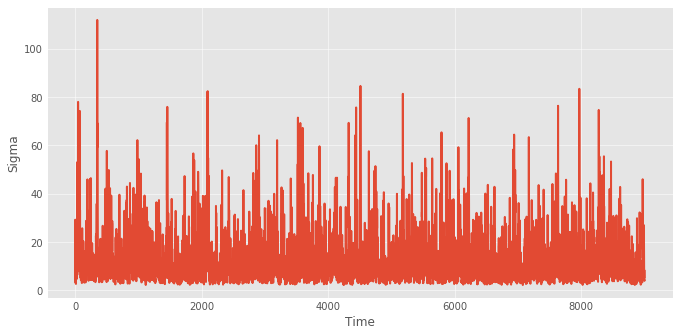

In [28]:
plt.figure(figsize=(10,5))
plt.plot(range(len(X)), compute_squared_sigmas(X, np.sqrt(np.mean(X**2)), (1, 0.5, 0.5)))
plt.xlabel('Time')
plt.ylabel('Sigma');

Now that we can compute the $\sigma_t$'s, we define the actual log likelihood function. This function takes as input our observations $x$ and $\theta$ and return - $\mathcal{L(\theta)}$. It is important to note that we return the negative log likelihood, as this way our numerical optimizer can minimize the function while maximizing the log likelihood.

Note that we are constantly re-computing the $\sigma_t$'s in this function.

In [29]:
def negative_log_likelihood(X, theta):
    
    T = len(X)
    
    # estimate initial sigma squared
    initial_sigma = np.sqrt(np.mean(X ** 2))
    
    # generate the squared sigma values
    sigma2 = compute_squared_sigmas(X, initial_sigma, theta)
    
    # now actually compute
    return -sum(
        [-np.log(np.sqrt(2.0 * np.pi)) -
         (X[t] ** 2) / (2.0 * sigma2[t]) -
         0.5 * np.log(sigma2[t]) for
         t in range(T)]
    )

Now we perform numerical optimization to find our estimate for:

$$\hat \theta = \arg \max \limits_{a_0,a_1,b_1} \mathcal{L(\theta)} = \arg \min \limits_{a_0,a_1,b_1} - \mathcal{L(\theta)} $$

We have some constraints on this:

$$a_1 \geq 0,b_1 \geq 0, a_1+b_1 < 1 $$

In [30]:
# make our objective function by plugging X into our log likelihood function
objective = partial(negative_log_likelihood, X)

# define the constraints for our minimizer
def constraint1(theta):
    return np.array([1 - (theta[1] + theta[2])])

def constraint2(theta):
    return np.array([theta[1]])

def constraint3(theta):
    return np.array([theta[2]])

cons = ({'type': 'ineq', 'fun': constraint1},
       {'type': 'ineq', 'fun': constraint2},
       {'type': 'ineq', 'fun': constraint3})

# actually do the minimization
result = scipy.optimize.minimize(objective, (1, 0.5, 0.5),
                                method='SLSQP',
                                constraints = cons)

theta_mle = result.x
print('theta MLE: ' + str(theta_mle))

/Users/corentinvibert/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


theta MLE:[1.1036755  0.09747704 0.78974979]


Now we want a way to check our estimate. We look at two things:

1. How fat are the tails of the residuals.
2. How normal are the residuals under the Jarque-Bera normality test.

we do both in our `check_theta_estimate` function.

In [32]:
def check_theta_estimate(X, theta_estimate):
    initial_sigma = np.sqrt(np.mean(X ** 2))
    sigma = np.sqrt(compute_squared_sigmas(X, initial_sigma, theta_estimate))
    epsilon = X / sigma
    print('Tails table')
    print(compare_tails_to_normal(epsilon / np.std(epsilon)))
    print(' ')
    
    _, pvalue, _, _ = jarque_bera(epsilon)
    print('Jarque-Bera probability normal: ' + str(pvalue))
    
check_theta_estimate(X, theta_mle)

Tails table
[[1.62555556e-01 2.33333333e-02 1.77777778e-03 0.00000000e+00]
 [1.58655254e-01 2.27501319e-02 1.34989803e-03 3.16712418e-05]]
 
Jarque-Bera probability normal: 0.384469878827675


## GMM for estimating GARCH(1,1) parameters

We've just computed an estimate using MLE, but we can also use Generalized Method of Moments (GMM) to estimate the GARCH(1,1) parameters.

To do this, we need to define our moments. We use 4.

1. The residual $\hat \epsilon_t = \frac{x_t}{\hat \sigma_t}$
2. The variance of the residual $\hat \epsilon^2_t$
3. The skew moment $\frac{\mu_3}{\hat \sigma^3_t} = (\hat \epsilon_t - E[\hat \epsilon_t])^3 / \hat \sigma^3_t$
4. The kurtosis moment $\mu_4 / \hat \sigma^4_t = (\hat \epsilon_t - E[\hat \epsilon_t])^4 / \hat \sigma^4_t$

In [33]:
# the nth standardized moment
# skewness is 3, kurtosis is 4
def standardized_moment(x, mu, sigma, n):
    return((x - mu) ** n) / (sigma ** n)

GMM now has three steps.

Start with $W$ as the identity matrix.

1. Estimate $\hat \theta_1$ by using numerical optimization to minimize.

$$\min \limits_{\theta \in \Theta} \left (\frac{1}{T} \sum^T_{t=1} g(x_t,\hat \theta ) \right)' W \left (\frac{1}{T} \sum^T_{t=1}g(x_t,\hat \theta \right)$$

2. Recompute $W$ based on the covariances of the estimated $\theta$ (focus more on parameters with explanatory power).

$$\hat W_{i+1}=\left (\frac{1}{T}\sum^T_{t=1}g(x_t,\hat \theta_i)g(x_t,\hat \theta_i)' \right)^{-1} $$

3. Repeat until $|\hat \theta_{i+1} - \hat \theta_i| < \epsilon$ or we reach an iteration threshold.

Initialize $W$ and $T$ and define the objective function we need to minimize.

In [39]:
def gmm_objective(X, W, theta):
    # Compute the residuals for X and theta
    initial_sigma = np.sqrt(np.mean(X ** 2))
    sigma = np.sqrt(compute_squared_sigmas(X, initial_sigma, theta))
    e = X / sigma
    
    # Compute the mean moments
    m1 = np.mean(e)
    m2 = np.mean(e ** 2) - 1
    m3 = np.mean(standardized_moment(e, np.mean(e), np.std(e), 3))
    m4 = np.mean(standardized_moment(e, np.mean(e), np.std(e), 4) - 3)
    
    G = np.matrix([m1, m2, m3, m4]).T
    
    return np.asscalar(G.T * W * G)

def gmm_variance(X, theta):
    # Compute the residuals for X and theta    
    initial_sigma = np.sqrt(np.mean(X ** 2))
    sigma = np.sqrt(compute_squared_sigmas(X, initial_sigma, theta))
    e = X / sigma

    # Compute the squared moments
    m1 = e ** 2
    m2 = (e ** 2 - 1) ** 2
    m3 = standardized_moment(e, np.mean(e), np.std(e), 3) ** 2
    m4 = (standardized_moment(e, np.mean(e), np.std(e), 4) - 3) ** 2
    
    # Compute the covariance matrix g * g'
    T = len(X)
    s = np.ndarray((4, 1))
    for t in range(T):
        G = np.matrix([m1[t], m2[t], m3[t], m4[t]]).T
        s = s + G * G.T
    
    return s / T

Now ready to do the iterated minimization step.

In [40]:
# Initialize GMM parameters
W = np.identity(4)
gmm_iterations = 10

# First guess
theta_gmm_estimate = theta_mle

# Perform iterated GMM
for i in range(gmm_iterations):
    # Estimate new theta
    objective = partial(gmm_objective, X, W)
    result = scipy.optimize.minimize(objective, theta_gmm_estimate, constraints=cons)
    theta_gmm_estimate = result.x
    print('Iteration ' + str(i) + ' theta: ' + str(theta_gmm_estimate))
    
    # Recompute W
    W = np.linalg.inv(gmm_variance(X, theta_gmm_estimate))
    

check_theta_estimate(X, theta_gmm_estimate)

/Users/corentinvibert/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  from ipykernel import kernelapp as app


Iteration 0 theta: [1.11495562 0.05551948 0.82769624]
Iteration 1 theta: [1.11486804 0.05521374 0.82686378]
Iteration 2 theta: [1.11486669 0.05520122 0.82685118]
Iteration 3 theta: [1.11486669 0.05520122 0.82685118]
Iteration 4 theta: [1.11486669 0.05520122 0.82685118]
Iteration 5 theta: [1.11486669 0.05520122 0.82685118]
Iteration 6 theta: [1.11486669 0.05520122 0.82685118]
Iteration 7 theta: [1.11486669 0.05520122 0.82685118]
Iteration 8 theta: [1.11486669 0.05520122 0.82685118]
Iteration 9 theta: [1.11486669 0.05520122 0.82685118]
Tails table
[[1.62222222e-01 2.27777778e-02 2.11111111e-03 1.11111111e-04]
 [1.58655254e-01 2.27501319e-02 1.34989803e-03 3.16712418e-05]]
 
Jarque-Bera probability normal: 0.6538551216488608


## Predicting the future: how to actually use what we've done

Now that we've fitted a model to our observations, we want to be able to predict what the future volatility will look like. To do this, we can just simulate more values using our original GARCH dynamics and the estimated parameters.

The first thing we do is compute an initial $\sigma_t$. We compute our squared sigmas and take the last one.

In [41]:
sigma_hats = np.sqrt(compute_squared_sigmas(X, np.sqrt(np.mean(X**2)), theta_mle))
initial_sigma = sigma_hats[-1]
initial_sigma

2.710555070421193

Now we just sample values walking forward.

In [42]:
a0_estimate = theta_gmm_estimate[0]
a1_estimate = theta_gmm_estimate[1]
b1_estimate = theta_gmm_estimate[2]

X_forecast, sigma_forecast = simulate_GARCH(100, a0_estimate, a1_estimate, b1_estimate, initial_sigma)

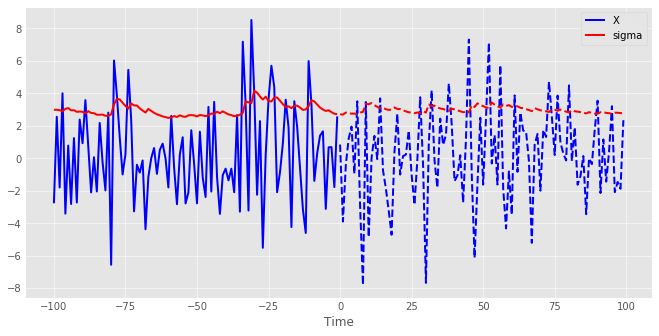

In [43]:
plt.figure(figsize=(10,5))
plt.plot(range(-100, 0), X[-100:], 'b-')
plt.plot(range(-100, 0), sigma_hats[-100:], 'r-')
plt.plot(range(0, 100), X_forecast, 'b--')
plt.plot(range(0, 100), sigma_forecast, 'r--')
plt.xlabel('Time')
plt.legend(['X', 'sigma']);

One should note that because we are moving forward using a random walk, this analysis is supposed to give us a sense of the magnitude of sigma and therefore the risk we could face. It is not supposed to accurately model future values of X. In practice you would probably want to use Monte Carlo sampling to generate thousands of future scenarios, and then look at the potential range of outputs. We can try it now. Keep in mind that this is a fairly simplistic way of doing this analysis, and that better techniques, such as Bayesian cones, exist.

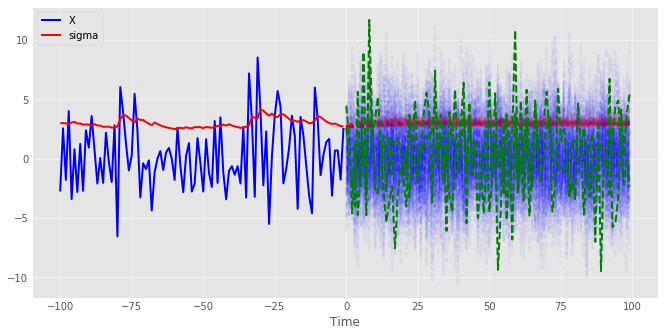

In [44]:
plt.figure(figsize=(10,5))
plt.plot(range(-100, 0), X[-100:], 'b-')
plt.plot(range(-100, 0), sigma_hats[-100:], 'r-')
plt.xlabel('Time')
plt.legend(['X', 'sigma'])

max_X = [-np.inf]
min_X = [np.inf]
for i in range(100):
    X_forecast, sigma_forecast = simulate_GARCH(100, a0_estimate, a1_estimate, b1_estimate, initial_sigma)
    if max(X_forecast) > max(max_X):
        max_X = X_forecast
    elif min(X_forecast) < min(max_X):
        min_X = X_forecast
    plt.plot(range(0, 100), X_forecast, 'b--', alpha=0.05)
    plt.plot(range(0, 100), sigma_forecast, 'r--', alpha=0.05)

# Draw the most extreme X values specially
plt.plot(range(0, 100), max_X, 'g--', alpha=1.0)
plt.plot(range(0, 100), min_X, 'g--', alpha=1.0);